In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import (roc_auc_score, average_precision_score, 
                             confusion_matrix, classification_report, roc_curve, precision_recall_curve)
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
from imblearn.over_sampling import SMOTE
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
print("="*70)
print("FRAUD DETECTION MODEL - COMPLETE PIPELINE")
print("="*70)

FRAUD DETECTION MODEL - COMPLETE PIPELINE


In [3]:
print("\n[STEP 1] Loading data...")
try:
    df = pd.read_csv('fraud_data.csv')
    print(f"\nDataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'fraud_data.csv' not found. Please check the file path.")
    raise

print(f"\nDataset shape: {df.shape}")
print("\nColumns:")
print(df.columns.tolist())


[STEP 1] Loading data...

Dataset loaded successfully!

Dataset shape: (500, 7)

Columns:
['TransactionID', 'Amount', 'Time', 'Location', 'MerchantCategory', 'CardHolderAge', 'IsFraud']


In [4]:
print("\nData types:")
print(df.dtypes)

print("\nBasic statistics:")
print(df.describe(include='all'))


Data types:
TransactionID         int64
Amount              float64
Time                  int64
Location             object
MerchantCategory     object
CardHolderAge       float64
IsFraud               int64
dtype: object

Basic statistics:
        TransactionID       Amount          Time Location MerchantCategory  \
count      500.000000   475.000000    500.000000      475              500   
unique            NaN          NaN           NaN        5                5   
top               NaN          NaN           NaN    Miami        Groceries   
freq              NaN          NaN           NaN      104              110   
mean       250.500000   641.112753  41141.482000      NaN              NaN   
std        144.481833  1044.448065  25614.468967      NaN              NaN   
min          1.000000     6.060000     55.000000      NaN              NaN   
25%        125.750000   243.780000  18726.250000      NaN              NaN   
50%        250.500000   518.810000  40772.000000      Na

In [6]:
print("\n[STEP 2] Analyzing missing values...")
missing_counts = df.isnull().sum()
missing_pct = (missing_counts / len(df)) * 100
missing_df = pd.DataFrame({
    'Column': missing_counts.index,
    'Missing Count': missing_counts.values,
    'Missing %': missing_pct.values
})
print(missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing %', ascending=False))


[STEP 2] Analyzing missing values...
          Column  Missing Count  Missing %
1         Amount             25        5.0
3       Location             25        5.0
5  CardHolderAge             24        4.8


In [7]:
# Analyze fraud rate in rows with missing values
if df.isnull().any().any():
    missing_mask = df.isnull().any(axis=1)
    fraud_in_missing = df[missing_mask]['IsFraud'].mean()
    fraud_in_complete = df[~missing_mask]['IsFraud'].mean()
    print(f"\nFraud rate in rows with missing data: {fraud_in_missing:.2%}")
    print(f"Fraud rate in complete rows: {fraud_in_complete:.2%}")


Fraud rate in rows with missing data: 5.88%
Fraud rate in complete rows: 5.32%


In [8]:
print("\n[STEP 3] Target variable analysis...")
print(f"\nFraud distribution:")
fraud_counts = df['IsFraud'].value_counts()
print(fraud_counts)
print(f"\nFraud ratio: {df['IsFraud'].mean():.2%}")
print(f"Class imbalance ratio: 1:{int(fraud_counts[0]/fraud_counts[1])}")


[STEP 3] Target variable analysis...

Fraud distribution:
IsFraud
0    473
1     27
Name: count, dtype: int64

Fraud ratio: 5.40%
Class imbalance ratio: 1:17


In [9]:
df_features = df.drop('TransactionID', axis=1).copy()

# Create time-based features from timestamp
# df_features['Hour'] = pd.to_datetime(df_features['Time'], unit='s').dt.hour
# df_features['DayOfWeek'] = pd.to_datetime(df_features['Time'], unit='s').dt.dayofweek
# df_features['IsWeekend'] = (df_features['DayOfWeek'] >= 5).astype(int)
if np.issubdtype(df_features['Time'].dtype, np.number):
    df_features['Hour'] = pd.to_datetime(df_features['Time'], unit='s').dt.hour
    df_features['DayOfWeek'] = pd.to_datetime(df_features['Time'], unit='s').dt.dayofweek
else:
    df_features['Hour'] = pd.to_datetime(df_features['Time']).dt.hour
    df_features['DayOfWeek'] = pd.to_datetime(df_features['Time']).dt.dayofweek
df_features['IsWeekend'] = (df_features['DayOfWeek'] >= 5).astype(int)

# Create amount-based features
df_features['Amount_Log'] = np.log1p(df_features['Amount'])

# Amount buckets (low, medium, high transactions)
# df_features['Amount_Bucket'] = pd.cut(df_features['Amount'], 
#                                        bins=[0, 200, 500, df_features['Amount'].max()],
#                                        labels=['Low', 'Medium', 'High'])
max_amt = df_features['Amount_Log'].max()
bins = [0, 200, 500, max_amt] if max_amt > 500 else [0, max_amt/2, max_amt]
labels = ['Low', 'Medium', 'High'] if max_amt > 500 else ['Low', 'High']
df_features['Amount_Bucket'] = pd.cut(df_features['Amount_Log'], bins=bins, labels=labels)

In [10]:
print(f"\nNew features created:")
print(f"  - Hour (from Time)")
print(f"  - DayOfWeek (from Time)")
print(f"  - IsWeekend (from DayOfWeek)")
print(f"  - Amount_Log (log transform)")
print(f"  - Amount_Bucket (categorical)")


New features created:
  - Hour (from Time)
  - DayOfWeek (from Time)
  - IsWeekend (from DayOfWeek)
  - Amount_Log (log transform)
  - Amount_Bucket (categorical)


In [11]:
print("\n[STEP 5] Preparing data for modeling...")

# Define feature columns (exclude target and original Time)
feature_cols = ['Amount', 'Amount_Log', 'Hour', 'DayOfWeek', 'IsWeekend',
                'Location', 'MerchantCategory', 'Amount_Bucket', 'CardHolderAge']

X = df_features[feature_cols].copy()
y = df_features['IsFraud'].copy()


[STEP 5] Preparing data for modeling...


In [12]:
print(f"\nFeatures: {feature_cols}")
print(f"X shape: {X.shape}, y shape: {y.shape}")


Features: ['Amount', 'Amount_Log', 'Hour', 'DayOfWeek', 'IsWeekend', 'Location', 'MerchantCategory', 'Amount_Bucket', 'CardHolderAge']
X shape: (500, 9), y shape: (500,)


In [13]:
print("\n[STEP 6] Splitting data...")

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
print(f"Train set: {X_train.shape[0]} samples ({y_train.mean():.2%} fraud)")
print(f"Test set:  {X_test.shape[0]} samples ({y_test.mean():.2%} fraud)")


[STEP 6] Splitting data...
Train set: 400 samples (5.50% fraud)
Test set:  100 samples (5.00% fraud)


In [14]:
print("\n[STEP 7] Handling missing values...")

# Identify numeric and categorical columns
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

print(f"\nNumeric features: {numeric_cols}")
print(f"Categorical features: {categorical_cols}")


[STEP 7] Handling missing values...

Numeric features: ['Amount', 'Amount_Log', 'Hour', 'DayOfWeek', 'IsWeekend', 'CardHolderAge']
Categorical features: ['Location', 'MerchantCategory', 'Amount_Bucket']


In [15]:
# num_imputer = SimpleImputer(strategy='median')
# X_train[numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
# X_test[numeric_cols] = num_imputer.transform(X_test[numeric_cols])
# Impute numeric
num_imputer = SimpleImputer(strategy='median')
X_train.loc[:, numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test.loc[:, numeric_cols] = num_imputer.transform(X_test[numeric_cols])

# Impute categorical
cat_imputer = SimpleImputer(strategy='most_frequent')
X_train.loc[:, categorical_cols] = cat_imputer.fit_transform(X_train[categorical_cols])
X_test.loc[:, categorical_cols] = cat_imputer.transform(X_test[categorical_cols])

In [16]:
print(f"Missing values after imputation:")
print(f"  Train: {X_train.isnull().sum().sum()}")
print(f"  Test:  {X_test.isnull().sum().sum()}")

Missing values after imputation:
  Train: 0
  Test:  0


In [18]:
print("\n[STEP 8] Encoding categorical variables...")
# for col in categorical_cols:
#     le = LabelEncoder()
#     # Fit on train
#     X_train[col] = le.fit_transform(X_train[col].astype(str))
#     # Handle unseen categories in test
#     X_test[col] = X_test[col].astype(str).map(
#         lambda x: le.transform([x])[0] if x in le.classes_ else -1
#     )
# print(f"Encoding complete. Sample encoded values:")
# print(X_train.head())

from sklearn.preprocessing import OrdinalEncoder
encoder = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)

X_train[categorical_cols] = X_train[categorical_cols].astype(float)
X_test[categorical_cols] = X_test[categorical_cols].astype(float)

X_train[categorical_cols] = encoder.fit_transform(X_train[categorical_cols])
X_test[categorical_cols] = encoder.transform(X_test[categorical_cols])

print(f"Encoding complete. Sample encoded values:")
print(X_train.head())



[STEP 8] Encoding categorical variables...
Encoding complete. Sample encoded values:
     Amount  Amount_Log  Hour  DayOfWeek  IsWeekend  Location  \
354   71.50    4.283587    23          3          0       0.0   
136  519.27    6.254348     9          3          0       2.0   
63   357.40    5.881650    15          3          0       4.0   
403  503.18    6.222933     7          3          0       2.0   
420  791.79    6.675558    10          3          0       1.0   

     MerchantCategory  Amount_Bucket  CardHolderAge  
354               4.0            1.0           42.0  
136               4.0            0.0           21.0  
63                0.0            0.0           33.0  
403               0.0            0.0           39.0  
420               2.0            0.0           61.0  


In [19]:
print("\n[STEP 9] Applying SMOTE to handle class imbalance...")

print(f"Before SMOTE:")
# print(f"  Fraud: {y_train.sum()}, Non-fraud: {(~y_train.astype(bool)).sum()}")
print(f"  Fraud: {sum(y_train == 1)}, Non-fraud: {sum(y_train == 0)}")

smote = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

print(f"After SMOTE:")
print(f"  Fraud: {y_train_balanced.sum()}, Non-fraud: {(~y_train_balanced.astype(bool)).sum()}")
print(f"  New fraud ratio: {y_train_balanced.mean():.2%}")


[STEP 9] Applying SMOTE to handle class imbalance...
Before SMOTE:
  Fraud: 22, Non-fraud: 378
After SMOTE:
  Fraud: 189, Non-fraud: 378
  New fraud ratio: 33.33%


In [20]:
# Time features
df['Hour'] = df['Time'] % 24
df['IsWeekend'] = (df['Time'] % 168 >= 120).astype(int)  # if week=7*24

# Amount features
df['LogAmount'] = np.log1p(df['Amount'])

# Age bins
df['AgeGroup'] = pd.cut(df['CardHolderAge'], bins=[18, 25, 40, 60, 100], labels=False)

In [21]:
from sklearn.preprocessing import LabelEncoder

for col in ['Location', 'MerchantCategory']:
    le = LabelEncoder()
    X_train_balanced[col] = le.fit_transform(X_train_balanced[col].astype(str))
    X_test[col] = le.transform(X_test[col].astype(str))

In [22]:
X_train['Location'] = X_train['Location'].astype('category')
X_train['MerchantCategory'] = X_train['MerchantCategory'].astype('category')

X_test['Location'] = X_test['Location'].astype('category')
X_test['MerchantCategory'] = X_test['MerchantCategory'].astype('category')

In [23]:
num_boost_round=1000

In [33]:
# from lightgbm import early_stopping, log_evaluation

# print("\n[STEP 10] Training LightGBM model...")

# train_data = lgb.Dataset(X_train_balanced, label=y_train_balanced)
# test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

# params = {
#     'objective': 'binary',
#     'metric': 'auc',
#     'boosting_type': 'gbdt',
#     'num_leaves': 64,
#     'max_depth': -1,
#     'learning_rate': 0.01,
#     'feature_fraction': 0.7,
#     'bagging_fraction': 0.7,
#     'bagging_freq': 5,
#     'scale_pos_weight': len(y_train_balanced[y_train_balanced==0]) / len(y_train_balanced[y_train_balanced==1]),
#     'random_state': 42
# }


# model_lgb = lgb.train(
#     params,
#     train_data,
#     num_boost_round=200,
#     valid_sets=[test_data],
#     valid_names=['test'],
#     callbacks=[early_stopping(stopping_rounds=30)]
# )
from lightgbm import early_stopping, log_evaluation

params = {
    'objective': 'binary',
    'metric': ['auc'],   # force it to log AUC
    'boosting_type': 'gbdt',
    'num_leaves': 64,
    'max_depth': -1,
    'learning_rate': 0.01,
    'feature_fraction': 0.7,
    'bagging_fraction': 0.7,
    'bagging_freq': 5,
    'scale_pos_weight': len(y_train_balanced[y_train_balanced==0]) / len(y_train_balanced[y_train_balanced==1]),
    'random_state': 42
}

cv_results = lgb.cv(
    params,
    train_data,
    num_boost_round=1000,
    nfold=5,
    stratified=True,
    seed=42,
    callbacks=[early_stopping(stopping_rounds=30), log_evaluation(50)]
)

print("Available keys:", cv_results.keys())   # debug keys


[LightGBM] [Info] Number of positive: 151, number of negative: 302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 453, number of used features: 7
[LightGBM] [Info] Number of positive: 151, number of negative: 302
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 617
[LightGBM] [Info] Number of data points in the train set: 453, number of used features: 7
[LightGBM] [Info] Number of positive: 152, number of negative: 302
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[Li

In [99]:
params['is_unbalance'] = True

In [32]:
print("\n[STEP 11] Making predictions and evaluating...")

# Predictions
y_pred_proba_lgb = model_lgb.predict(X_test)
y_pred_lgb = (y_pred_proba_lgb >= 0.5).astype(int)


[STEP 11] Making predictions and evaluating...


In [33]:
lgb_auc = roc_auc_score(y_test, y_pred_proba_lgb)
lgb_pr_auc = average_precision_score(y_test, y_pred_proba_lgb)

In [34]:
print("\n" + "="*70)
print("LIGHTGBM PERFORMANCE")
print("="*70)
print(f"ROC-AUC Score: {lgb_auc:.4f}")
print(f"PR-AUC Score:  {lgb_pr_auc:.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lgb))
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lgb))


LIGHTGBM PERFORMANCE
ROC-AUC Score: 0.4316
PR-AUC Score:  0.0938

Confusion Matrix:
[[82 13]
 [ 4  1]]

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.86      0.91        95
           1       0.07      0.20      0.11         5

    accuracy                           0.83       100
   macro avg       0.51      0.53      0.51       100
weighted avg       0.91      0.83      0.87       100



In [35]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

In [36]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_balanced)
X_test_scaled = scaler.transform(X_test)

In [37]:
model_lr = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=42)
model_lr.fit(X_train_scaled, y_train_balanced)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'lbfgs'
,max_iter,1000
,multi_class,'deprecated'


In [38]:
y_pred_proba_lr = model_lr.predict_proba(X_test_scaled)[:, 1]
y_pred_lr = (y_pred_proba_lr >= 0.5).astype(int)

In [41]:
lr_auc = roc_auc_score(y_test, y_pred_proba_lr)
lr_pr_auc = average_precision_score(y_test, y_pred_proba_lr)

In [42]:
print("\n" + "="*70)
print("LOGISTIC REGRESSION PERFORMANCE")
print("="*70)
print(f"ROC-AUC Score: {lr_auc:.4f}")
print(f"PR-AUC Score:  {lr_pr_auc:.4f}")
print(f"\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred_lr))
print(f"\nClassification Report:")
print(classification_report(y_test, y_pred_lr))


LOGISTIC REGRESSION PERFORMANCE
ROC-AUC Score: 0.6084
PR-AUC Score:  0.1449

Confusion Matrix:
[[56 39]
 [ 2  3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.59      0.73        95
           1       0.07      0.60      0.13         5

    accuracy                           0.59       100
   macro avg       0.52      0.59      0.43       100
weighted avg       0.92      0.59      0.70       100



In [43]:
print("\n" + "="*70)
print("MODEL COMPARISON SUMMARY")
print("="*70)


MODEL COMPARISON SUMMARY


In [44]:
comparison_df = pd.DataFrame({
    'Model': ['LightGBM', 'Logistic Regression'],
    'ROC-AUC': [lgb_auc, lr_auc],
    'PR-AUC': [lgb_pr_auc, lr_pr_auc]
})
print(comparison_df)

                 Model   ROC-AUC    PR-AUC
0             LightGBM  0.431579  0.093829
1  Logistic Regression  0.608421  0.144875


In [45]:
winner = 'LightGBM' if lgb_auc > lr_auc else 'Logistic Regression'
improvement = abs(lgb_auc - lr_auc)
print(f"\nBest Model: {winner}")
print(f"AUC Improvement: {improvement:.4f} ({improvement*100:.2f}%)")


Best Model: Logistic Regression
AUC Improvement: 0.1768 (17.68%)


In [46]:
print("\n[STEP 14] Feature importance analysis...")

importance = model_lgb.feature_importance(importance_type='gain')
feature_importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importance
}).sort_values('Importance', ascending=False)

print("\nTop 10 Most Important Features:")
print(feature_importance_df.head(10))


[STEP 14] Feature importance analysis...

Top 10 Most Important Features:
            Feature   Importance
0            Amount  1605.673941
8     CardHolderAge  1443.069551
2              Hour  1056.158721
6  MerchantCategory   700.888699
1        Amount_Log   640.083403
5          Location   627.253060
7     Amount_Bucket    85.805962
4         IsWeekend     0.000000
3         DayOfWeek     0.000000



[STEP 15] Creating visualizations...


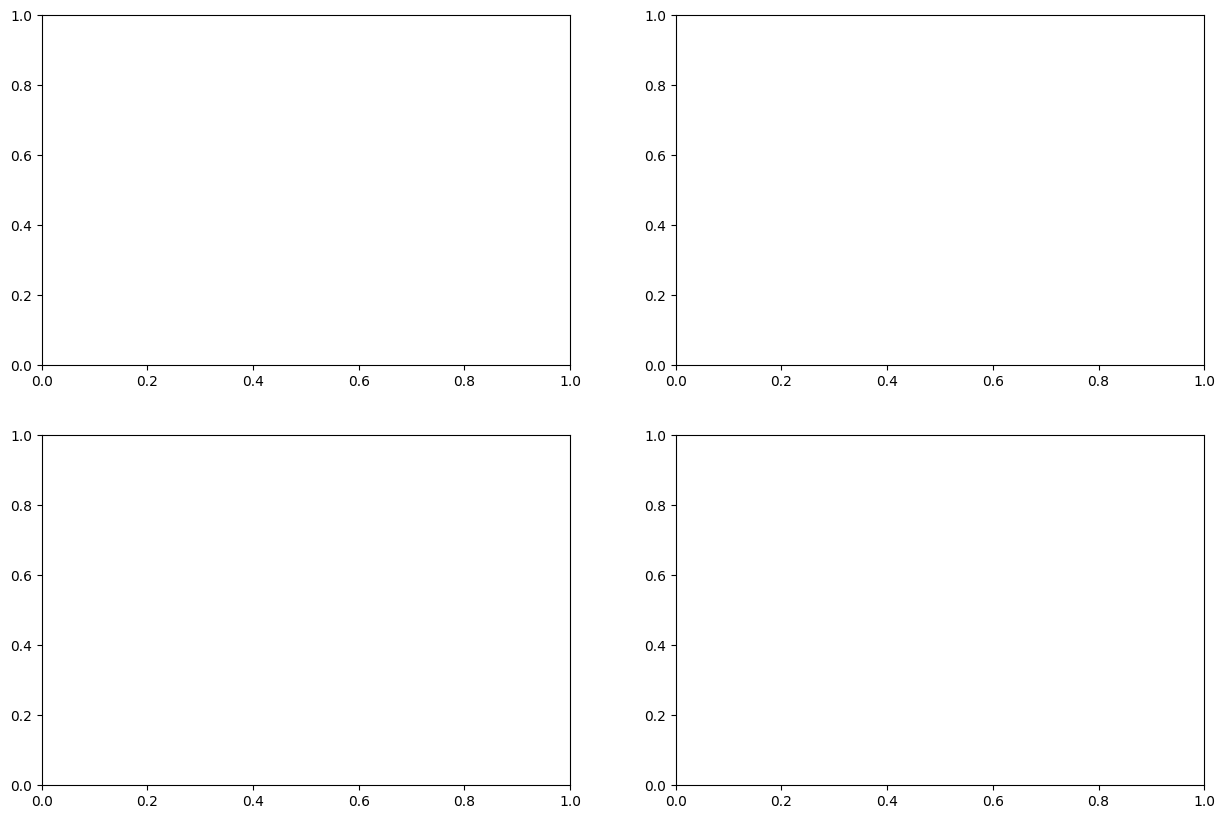

In [51]:
print("\n[STEP 15] Creating visualizations...")

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# ROC Curve
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_proba_lgb)
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_proba_lr)

In [52]:
axes[0, 0].plot(fpr_lgb, tpr_lgb, label=f'LightGBM (AUC={lgb_auc:.3f})')
axes[0, 0].plot(fpr_lr, tpr_lr, label=f'LogReg (AUC={lr_auc:.3f})')
axes[0, 0].plot([0, 1], [0, 1], 'k--', label='Random')
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('ROC Curve Comparison')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

In [53]:
top_features = feature_importance_df.head(10)
axes[0, 1].barh(top_features['Feature'], top_features['Importance'])
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('Top 10 Feature Importance (LightGBM)')
axes[0, 1].invert_yaxis()

In [54]:
cm_lgb = confusion_matrix(y_test, y_pred_lgb)
sns.heatmap(cm_lgb, annot=True, fmt='d', cmap='Blues', ax=axes[1, 0])
axes[1, 0].set_title('Confusion Matrix - LightGBM')
axes[1, 0].set_ylabel('True Label')
axes[1, 0].set_xlabel('Predicted Label')

Text(0.5, 80.7222222222222, 'Predicted Label')

In [55]:
cm_lr = confusion_matrix(y_test, y_pred_lr)
sns.heatmap(cm_lr, annot=True, fmt='d', cmap='Greens', ax=axes[1, 1])
axes[1, 1].set_title('Confusion Matrix - Logistic Regression')
axes[1, 1].set_ylabel('True Label')
axes[1, 1].set_xlabel('Predicted Label')

Text(0.5, 80.7222222222222, 'Predicted Label')

In [56]:
plt.tight_layout()
plt.savefig('fraud_detection_results.png', dpi=300, bbox_inches='tight')
plt.show()

<Figure size 640x480 with 0 Axes>

In [57]:
print("\n" + "="*70)
print("ANALYSIS COMPLETE!")
print("="*70)
print(f"\nResults saved to: fraud_detection_results.png")


ANALYSIS COMPLETE!

Results saved to: fraud_detection_results.png
